## Introduction

We have 2 types of datasets, CoreTrends and NSDUH. Within these 2 types we have an individual dataset for each year, 2018, 2019, 2021* : 
<br>
<ins>NSDUH</ins> - National Survey on Drug Use and Health which contains data on mental health
<br>
<ins>Core Trends</ins> - Pew Research Core trends survey which contains data on social media use
With this data we are trying to answer whether there is a correlation between Social Media use and negative Mental health outcomes.
<br>
*2020 was not included because the Core Trends survey for that year doesn't exist and there are no Core Trends surveys beyond 2021.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from ml_analysis import convertObjects, predictUsageOfAgeGroups, randomForest
from helper_code import *

## Changes

Our scope hasn't changed much. We're still attempting to find a correllation between social media and negative mental health outcomes. The only relatively major change is instead of finding a direct relationship through a survey that directly asks if social media has affected the individual, we must utilize seperate datasets for social media usage and mental health effects to find a correllation because there were no other large enough datasets available.

## EDA

## Visual 1

##### Read in Datasets and get all columns valuable to us after choosing manually

In [2]:
NSDUH2021Cols = ["AGE3","IRSEX","AUINPYR","AURXYR","YEATNDYR","YESCHFLT","YEPRBSLV","DSTNRV30","DSTHOP30","DSTCHR30","DSTNGD30","DSTWORST","DSTNRV12","DSTHOP12","DSTCHR12","DSTNGD12","IMPCONCN","IMPGOUT","IMPPEOP","IMPSOC","IMPSOCM","SUICTHNK","SUIPLANYR","ADDPREV"]; NSDUH201819Cols = ["AGE2", "IRSEX", "AUINPYR","AURXYR","YEATNDYR","YESCHFLT","YEPRBSLV","DSTNRV30","DSTHOP30","DSTCHR30","DSTNGD30","DSTWORST","DSTNRV12","DSTHOP12","DSTCHR12","DSTNGD12","IMPCONCN","IMPGOUT","IMPPEOP","IMPSOC","IMPSOCM","SUICTHNK","ADDPREV"]
CoreTrends2021Cols = ["web1a", "web1b", "web1c", "web1d", "web1e","sns2a", "sns2b", "sns2c", "sns2d", "sns2e","gender", "age"]; CoreTrends2019Cols = ["web1a", "web1b", "web1c", "web1d", "web1e","sns2a", "sns2b", "sns2c", "sns2d", "sns2e","sex", "age"]; CoreTrends2018Cols = ["web1a", "web1b", "web1c", "web1d", "web1e","sns2a", "sns2b", "sns2c", "sns2d", "sns2e","sex", "age"]

NSDUH2019_wantedCols = readInAndGetWantedColumns("datasets/National Survey on Drug Use and Health 2019/NSDUH_2019_Tab.txt", "txt", NSDUH201819Cols); NSDUH2018_wantedCols = readInAndGetWantedColumns("datasets/National Survey on Drug Use and Health 2018/NSDUH_2018_Tab.tsv", "tsv", NSDUH201819Cols); NSDUH2021_wantedCols = readInAndGetWantedColumns("datasets/National Survey on Drug Use and Health 2021/NSDUH_2021_Tab.txt", "txt", NSDUH2021Cols)
CoreTrends2021_wantedCols = readInAndGetWantedColumns("datasets/Jan-25-Feb-8-2021-Core-Trends-Survey/Jan 25-Feb 8, 2021 - Core Trends Survey - CSV.csv", "csv", CoreTrends2021Cols); CoreTrends2019_wantedCols = readInAndGetWantedColumns("datasets/January-8-February-7-2019-Core-Trends-Survey-SPSS/January 8-February 7, 2019 - Core Trends Survey - CSV.csv", "csv", CoreTrends2019Cols); CoreTrends2018_wantedCols = readInAndGetWantedColumns("datasets/January 3-10, 2018 - Core Trends Survey/January 3-10, 2018 - Core Trends Survey - CSV.csv", "csv", CoreTrends2018Cols)

##### Clean up data (code in helper_code.py)
For both Datasets, first all data is converted to numeric
<ins>CoreTrends Dataset [cleanUpCoreTrends()]: </ins>
<br>Drop 'sns2a' column because all values are empty.
<br>Remove values over 98 because those indicate a refused or skipped answer.
<br>Cut the age data into bins representing ranges of ages to match with NSDUH.
<br>Melt the data into longform, using selected id and values (in this case age and web1a...web1e).
<br>Convert the values from ints to more descriptive value (1->Uses Social Media, 2->Doesnt Use Social Media), this eliminates a manual labeling step later and drop null values.
<br><br>
<ins>NSDUH Dataset [cleanUpNSDUH()]:</ins>
<br>Remove values over 85 because those indicate a refused or skipped answer.
<br>Cut the age data into matching bins as CoreTrends
<br>Cut the desired column values into two bins for more relevant/consistent data since most values are in a range.
<br>Melt the data into longform, using selected id and values (in this case either AGE2/AGE3 depending on year, and desired mental health column)
<br>Rename AGE2/AGE3 column to age, for consistency and drop null values


In [3]:
CoreTrends_id = ['age']; CoreTrends_values = ["web1a", "web1b", "web1c", "web1d", "web1e"]
NSDUH_id=['AGE2']; NSDUH_values = ['DSTCHR12']

CoreTrends2018_long = cleanUpCoreTrends(CoreTrends2018_wantedCols, CoreTrends_id, CoreTrends_values); CoreTrends2019_long = cleanUpCoreTrends(CoreTrends2019_wantedCols, CoreTrends_id, CoreTrends_values); CoreTrends2021_long = cleanUpCoreTrends(CoreTrends2021_wantedCols, CoreTrends_id, CoreTrends_values)
NSDUH2018_long = cleanUpNSDUH(NSDUH2018_wantedCols,NSDUH_id,NSDUH_values); NSDUH2019_long = cleanUpNSDUH(NSDUH2019_wantedCols,NSDUH_id,NSDUH_values); NSDUH2021_long = cleanUpNSDUH(NSDUH2021_wantedCols,['AGE3'],NSDUH_values)


##### Get Percentages

In [4]:
percDepressed_NSDUH2018 = getPercentage(NSDUH2018_long, "Depressed", "age", 2018); percDepressed_NSDUH2019 = getPercentage(NSDUH2019_long, "Depressed", "age", 2019); percDepressed_NSDUH2021 = getPercentage(NSDUH2021_long, "Depressed", "age", 2021)
SMUse_sum_CoreTrends2018 = getPercentage(CoreTrends2018_long, "Uses Social Media", "age", 2018); SMUse_sum_CoreTrends2019 = getPercentage(CoreTrends2019_long, "Uses Social Media", "age", 2019); SMUse_sum_CoreTrends2021 = getPercentage(CoreTrends2021_long, "Uses Social Media", "age", 2021)

CoreTrends_SMUseSum_concat = pd.concat([SMUse_sum_CoreTrends2018,SMUse_sum_CoreTrends2019, SMUse_sum_CoreTrends2021])
NSDUH_concat = pd.concat([percDepressed_NSDUH2018,percDepressed_NSDUH2019,percDepressed_NSDUH2021])

##### Display final graph

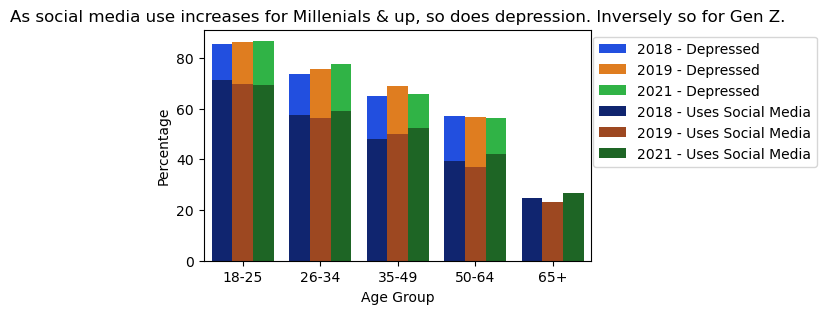

In [5]:
plt.figure(figsize=(5, 3))
sns.barplot(data=NSDUH_concat, x='age', y='percentage',hue='dataset', palette='bright')
sns.barplot(data=CoreTrends_SMUseSum_concat, x='age', y='percentage', hue='dataset' ,palette='dark')
plt.title("As social media use increases for Millenials & up, so does depression. Inversely so for Gen Z.")
plt.ylabel("Percentage")
plt.xlabel("Age Group")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))

The most interesting result from this data is non-obvious trends when looking at how social media usage changed throughout the 3 years compared to the percentage of people depressed within the age ranges.

For 18-25 year olds (roughly Gen Z), there was an inverse correlation. The percentage of those depressed consistently increased, while social media usage consistently decreased.

However for ages 26-49 (roughly Millenials & Gen X), both depression and social media usage percentages increased.

For ages 50-64, Depression remained relatively unchaged while social media usage increased. And for ages 60+ there was no data on Depression so a correllation cannot be made, unless we interpret that as people 65+ refusing to acknowledge mental health which would be an interesting result.

The most surprising result is regarding Gen Z having the inverse correlation with depression and social media usage, as one may have expected a result similar to those for Millenials/Gen X. However, what isn't surprising is the fact that the percentages of those depressed decreases throughout the generations as younger people are often more willing/open to acknowledge and in some cases even embrace their mental health struggles.

# Machine Learning

In [2]:
core2018 = pd.read_csv('datasets/January 3-10, 2018 - Core Trends Survey/January 3-10, 2018 - Core Trends Survey - CSV.csv')
core2018 = convertObjects(core2018)
predictUsageOfAgeGroups(core2018)

Accuracy: 0.34
Classification Report:
              precision    recall  f1-score   support

       18-24       0.37      0.43      0.40        97
       25-34       0.25      0.32      0.28       140
       35-44       0.10      0.01      0.01       133
       45-54       0.28      0.12      0.17       154
       55-64       0.21      0.24      0.22       186
         65+       0.47      0.67      0.55       291

    accuracy                           0.34      1001
   macro avg       0.28      0.30      0.27      1001
weighted avg       0.30      0.34      0.31      1001



In [3]:
core2018 = pd.read_csv('datasets/January 3-10, 2018 - Core Trends Survey/January 3-10, 2018 - Core Trends Survey - CSV.csv')
drop_columns = ['usr', 'pial5b', 'pial5c', 'pial5d', 'pial11a', 'pial11ao@', 'pial12']
core2018 = core2018.drop(drop_columns, axis=1)
core2018 = convertObjects(core2018)
randomForest(core2018, 'intfreq')

Accuracy: 57.93%
Classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        98
         1.0       0.50      0.27      0.35       201
         2.0       0.54      0.83      0.65       360
         3.0       0.11      0.02      0.03        59
         4.0       0.20      0.02      0.04        46
         5.0       0.39      0.26      0.31        35
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         1

    accuracy                           0.58       801
   macro avg       0.34      0.30      0.30       801
weighted avg       0.53      0.58      0.52       801



/Users/luis/.pyenv/versions/3.11.5/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luis/.pyenv/versions/3.11.5/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luis/.pyenv/versions/3.11.5/envs/datascience/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

After feeding the 2018 Core Trends data frame to the SVM model, we get a very low accuracy number. We're not entirely sure why this could be the case, but due to these results we plan on using Random Decision Forest to help with finding the right columns to feed the model. For the results above, we are feeding it the internet frequency, the age, and which social medias they specifically use. There could be other responses that could help like, income, race, and marital status which are in the data.
This data frame has good features such as how much said users use certain social medias, 5 being rarely and 1 being several times a day. Which is what we're trying to predict, which social media is used the most amongst age groups.

After implementing the Random Decision Forest, we see much better results, however again this is still only being fed the 2018 data. I've created a method for cleaning the 'object' datatype columns in a dataframe and for NaN or null responses, it makes the response -1, however this only handles the case for the 2018 data. Fully merging all the data will probably require handling extra cases. 

What we plan to do is merge all the years, 2018, 2019 and 2021 to give the model more data to have a better accuracy score. However, some of the newer tests added new questions so the combined data frame has to be merged together and cleaned for it to inputted properly.

# Reflection

Project Challenges:(1)Improving model accuracy beyond the current 58%.(2)Integrating varying yearly datasets and harmonizing the data for the model input.

Initial Insights: There is a year-by-year complex relationship between social media usage and age groups, with a notable inverse trend in Gen Z.

Concrete Results: We can see the Visual trends in data and current SVM model metrics, indicating room for improved classification.

Major Issues:(1)Dataset integration across years is problematic, affecting model performance.(2)Feature selection and model choice require reevaluation for capturing complex patterns.

Project Timeline:(1)Potential delays from data integration and feature refinement.(2)Need a little bit more time for model experimentation.

Project Viability: (1)The project's relevance to mental health justifies continuation.(2)Encouraging patterns and data complexity indicate potential for deeper insights with advanced modeling.


# Next Steps

For the next month, we believe the focus will be on improving the machine learning model's predictive performance and integrating the datasets from different years more effectively. There are still trends in the data that need to be explored and we know that our dataset is rich and complex which will lead to more informative visualizations. Here are some of the planned steps:
 
Data Integration and Preprocessing:(1)Merge 2018, 2019, and 2021 datasets, ensuring feature consistency and standardization.(2)Process data to handle NaN values, outliers, and inconsistencies post-merging.

Model Refinement:(1)Implement Recursive Feature Elimination and other methods for feature selection.(2)Explore gradient boosting machines and deep learning models, alongside existing ensemble methods.

Project Goal Evaluation in one month will focus on:(1)Enhanced model performance surpassing the 58% baseline.(2)The quality of insights linking social media usage to mental health.(3)The model's predictive reliability across demographics and over time.

